In [1]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import nltk
import numpy as np
import pandas as pd
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nares\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from pyspark.sql import SparkSession
# start spark session configured for spark nlp
spark = SparkSession.builder \
     .master("local[*]") \
     .config("spark.driver.memory","16G")\
     .config("spark.driver.maxResultSize", "0") \
     .config("spark.kryoserializer.buffer.max", "2000M")\
     .appName("Spark NLP") \
     .config("spark.jars.packages", 
             "com.johnsnowlabs.nlp:spark-nlp_2.11:2.3.5") \
     .getOrCreate()

In [3]:
data = pd.read_csv('counts.csv')
data.head()

,finished_bert,exploded_score
0,video offic mind busi david solomon tell g int...,positive
1,price lumber lbf sinc hit ytd high maci turnar...,positive
2,sai american dream dead,negative
3,barri silbert extrem optimist bitcoin predict ...,negative
4,satellit avoid attack space junk circl earth h...,na


In [4]:
data.shape

(28876, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28876 entries, 0 to 28875
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   finished_bert   28876 non-null  object
 1   exploded_score  28876 non-null  object
dtypes: object(2)
memory usage: 451.3+ KB


In [6]:
data.columns=['tweets','sentiment']

In [7]:
data.head()

,tweets,sentiment
0,video offic mind busi david solomon tell g int...,positive
1,price lumber lbf sinc hit ytd high maci turnar...,positive
2,sai american dream dead,negative
3,barri silbert extrem optimist bitcoin predict ...,negative
4,satellit avoid attack space junk circl earth h...,na


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [9]:
pat1 = r'@[A-Za-z0-9]+' # this is to remove any text with @....
pat2 = r'https?://[A-Za-z0-9./]+'  # this is to remove the urls
combined_pat = r'|'.join((pat1, pat2)) 
pat3 = r'[^a-zA-Z]' # to remove every other character except a-z & A-Z
combined_pat2 = r'|'.join((combined_pat,pat3)) # we combine pat1, pat2 and pat3 to pass it in the cleaning steps

all_stopwords = stopwords.words('english')
all_stopwords.append("rt")


In [27]:
ps = PorterStemmer()
cleaned_tweets = []

for i in range(0, len(data['tweets'])) :
    tweets = re.sub(combined_pat2,' ',data['tweets'][i])
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [ps.stem(word) for word in tweets if not word in all_stopwords]
    tweets = ' '.join(tweets)
    cleaned_tweets.append(tweets)
cleaned_tweets    

['video offic mind busi david solomon tell g intern learn wa',
 'price lumber lbf sinc hit ytd high maci turnaround still happen',
 'sai american dream dead',
 'barri silbert extrem optimist bitcoin predict new crypto entrant go zero',
 'satellit avoid attack space junk circl earth httpstcoahzivlqp pai oracl',
 'realmonei david butler favorit fang stock isnt realmoneysod alphabet',
 'dont miss convo favorit thinker samharrisorg httpstcouupvxiobch',
 'intellig docum nelson mandela make public',
 'senat want emerg alert go netflix spotifi etc',
 'hedg fund manag marc larsi sai bitcoin k possibl',
 'propo expedit appeal fight atampt time warner purcha',
 'roger feder uniqlo deal make athlet earn endor httpstcojqsoayebq',
 'bond trader ahead jerom powel come inflat expect httpstcodkdzlcymt via httpstcoucxeihpr',
 'alcoa cut adjust ebitda forecast cite tariff share slide httpstcomdmjxjnyi httpstcoofvwlhpi',
 'custom urg boycott mgm resort casino file lawsuit mass shoot victim httpstcodahkdp

In [11]:
final_tweet = pd.DataFrame(data=cleaned_tweets,columns=['tweets'])

In [12]:
final_tweet['target'] = data['sentiment']

In [13]:
final_tweet.head()

,tweets,target
0,video offic mind busi david solomon tell g int...,positive
1,price lumber lbf sinc hit ytd high maci turnar...,positive
2,sai american dream dead,negative
3,barri silbert extrem optimist bitcoin predict ...,negative
4,satellit avoid attack space junk circl earth h...,na


In [14]:
final_tweet.shape

(28876, 2)

In [15]:
final_tweet['target'] = final_tweet['target'].replace(['na'],'positive')

In [16]:
final_tweet['target'].value_counts()

positive    18600
negative    10276
Name: target, dtype: int64

In [17]:
positive_tweet = []
negative_tweet = []

for i in range(0, final_tweet.shape[0]):
    if final_tweet['target'][i] == 'negative':
        negative_tweet.append(final_tweet['tweets'][i])
    elif final_tweet['target'][i] == 'positive':
        positive_tweet.append(final_tweet['tweets'][i])

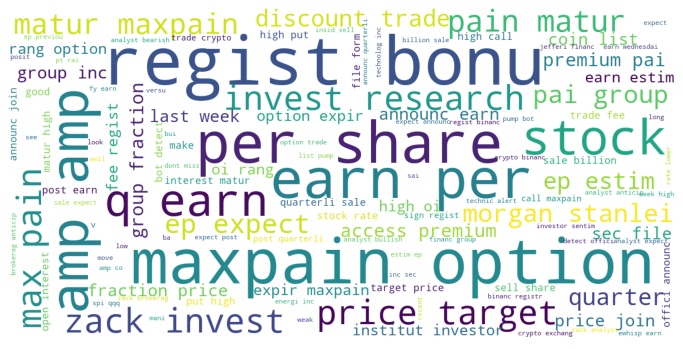

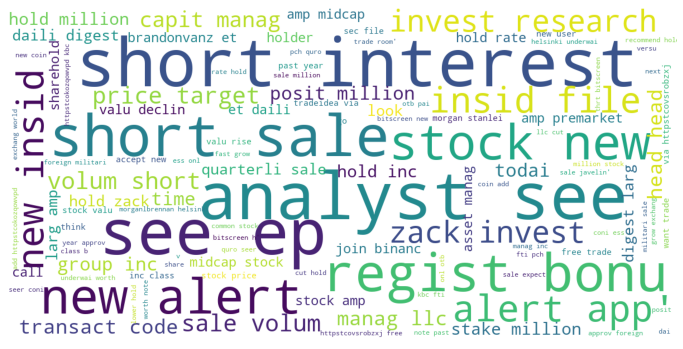

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(positive_tweet)
show_wordcloud(negative_tweet)

In [19]:
final_tweet.to_csv('clean_tweets.csv',header=True)

In [20]:
df = spark.read.csv("clean_tweets.csv",header=True)

In [21]:
df.head(10)

[Row(_c0='0', tweets='video offic mind busi david solomon tell g intern learn wa', target='positive'),
 Row(_c0='1', tweets='price lumber lbf sinc hit ytd high maci turnaround still happen', target='positive'),
 Row(_c0='2', tweets='sai american dream dead', target='negative'),
 Row(_c0='3', tweets='barri silbert extrem optimist bitcoin predict new crypto entrant go zero', target='negative'),
 Row(_c0='4', tweets='satellit avoid attack space junk circl earth httpstcoahzivlqp pai oracl', target='positive'),
 Row(_c0='5', tweets='realmonei david butler favorit fang stock isnt realmoneysod alphabet', target='positive'),
 Row(_c0='6', tweets='dont miss convo favorit thinker samharrisorg httpstcouupvxiobch', target='positive'),
 Row(_c0='7', tweets='intellig docum nelson mandela make public', target='positive'),
 Row(_c0='8', tweets='senat want emerg alert go netflix spotifi etc', target='negative'),
 Row(_c0='9', tweets='hedg fund manag marc larsi sai bitcoin k possibl', target='positive')

In [22]:
df.groupBy('target').count().show()

+--------+-----+
|  target|count|
+--------+-----+
|positive|18600|
|negative|10276|
+--------+-----+



In [23]:
(train_set, test_set) = df.randomSplit([0.60, 0.40], seed = 2142)

In [24]:
test_set.count()

11638

In [25]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [26]:
tokenizer = Tokenizer(inputCol="tweets", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(test_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(test_set.count())
roc_auc = evaluator.evaluate(predictions)

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.9258
ROC-AUC: 0.9564
